## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [39]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = "./data/data.txt"
if not os.path.exists(path_do_data):
    os.makedirs("./data/", exist_ok=True)
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc -O ./data/data.txt

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import Field, BucketIterator

# import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import utils
from utils import train, evaluate

torch.cuda.is_available()


True

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [41]:
tokenizer_W = WordPunctTokenizer()


def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [42]:
SRC = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

TRG = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data, format="tsv", fields=[("trg", TRG), ("src", SRC)]
)

In [43]:
# dataset, ff = dataset.split(split_ratio=0.01)

In [44]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])  # type: ignore

In [45]:
print(f"Number of training examples: {len(train_data.examples)}")  # type: ignore
print(f"Number of validation examples: {len(valid_data.examples)}")  # type: ignore
print(f"Number of testing examples: {len(test_data.examples)}")  # type: ignore

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [46]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [47]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9245
Unique tokens in target (en) vocabulary: 6716


Here are tokens from original (RU) corpus:

In [48]:
SRC.vocab.itos[::10]  # ,skj 1000

['<unk>',
 'от',
 'услугам',
 'гости',
 '«',
 'плоским',
 'езды',
 'отеле',
 'каналами',
 'вид',
 'все',
 'кухней',
 'центр',
 'барбекю',
 'микроволновой',
 'гостевой',
 'балкон',
 'шведский',
 'аэропорт',
 'косметическими',
 'гостиной',
 'ресторанов',
 '500',
 'нескольких',
 'де',
 'холодильник',
 'вашем',
 'гольф',
 'багажа',
 'машина',
 'как',
 'открытым',
 'утрам',
 'несколько',
 'парк',
 'железнодорожный',
 '400',
 'поселке',
 'магазинов',
 'ванные',
 'национального',
 'автомобиль',
 'курортного',
 'le',
 '11',
 'местных',
 'плеер',
 '45',
 'крытый',
 'множество',
 'доступ',
 'рынка',
 'уголком',
 'рабочий',
 'домашними',
 'трансфера',
 'подаются',
 'театра',
 '900',
 'региона',
 'деревянной',
 'тренажерный',
 'ежедневный',
 'лобби',
 'рестораном',
 'городке',
 'каналы',
 '32',
 'спальня',
 'собственные',
 'традиционном',
 'историческом',
 'письменный',
 'бильярд',
 'легко',
 'загородный',
 'готовят',
 'оборудован',
 'best',
 'арендовать',
 'детей',
 'камин',
 'совещаний',
 'al',


And from target (EN) corpus:

In [49]:
TRG.vocab.itos[::10]

['<unk>',
 '-',
 'away',
 'located',
 'drive',
 'features',
 'kitchen',
 'each',
 'terrace',
 'international',
 'dining',
 'well',
 'guest',
 '15',
 'served',
 'throughout',
 '&',
 'catering',
 'style',
 'every',
 'cuisine',
 'laundry',
 'sun',
 'traditional',
 'distance',
 'fitness',
 'tour',
 '9',
 'reception',
 'their',
 'both',
 'casa',
 'such',
 ')',
 'ironing',
 'grocery',
 'castle',
 'bbq',
 'surcharge',
 'bay',
 '11',
 'own',
 '700',
 'right',
 'additional',
 'century',
 'wide',
 'benefit',
 'wine',
 'court',
 'tvs',
 'complex',
 'mediterranean',
 'treatments',
 'loungers',
 'world',
 'da',
 'charming',
 'pension',
 'warm',
 'temple',
 'blue',
 'telephone',
 'houses',
 'non',
 'cafes',
 'golfing',
 'library',
 'fruit',
 'closest',
 'seafood',
 'walls',
 'standard',
 'travel',
 'boasting',
 'people',
 'beauty',
 'red',
 'seafront',
 'top',
 'setting',
 'organised',
 'approximately',
 'sunny',
 'across',
 'lies',
 'four',
 'east',
 'big',
 'premises',
 'ballet',
 'live',
 'extens

And here is example from train dataset:

In [50]:
print(vars(train_data.examples[9]))

{'trg': ['maritim', 'hotel', 'can', 'provide', 'a', 'shuttle', 'service', 'to', 'torp', 'sandefjord', 'airport', 'on', 'request', '.'], 'src': ['в', 'отеле', 'maritim', 'по', 'запросу', 'организуют', 'трансфер', 'до', 'аэропорта', 'саннефьорд', 'торп', '.']}


Let's check the length distributions:

Length distribution in Train data


(array([5.080e+02, 8.622e+03, 1.114e+04, 8.699e+03, 5.636e+03, 2.820e+03,
        1.420e+03, 6.870e+02, 2.680e+02, 1.000e+02, 6.100e+01, 2.200e+01,
        7.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <BarContainer object of 20 artists>)

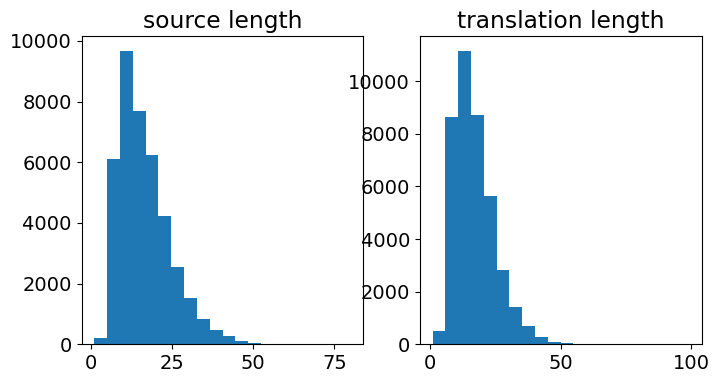

In [51]:
src_length = map(len, [vars(x)["src"] for x in train_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in train_data.examples])

print("Length distribution in Train data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

Length distribution in Test data


(array([1.200e+01, 8.290e+02, 1.241e+03, 1.694e+03, 1.096e+03, 1.079e+03,
        6.950e+02, 3.310e+02, 2.200e+02, 1.220e+02, 8.500e+01, 4.200e+01,
        1.600e+01, 2.000e+01, 4.000e+00, 7.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1. ,  4.6,  8.2, 11.8, 15.4, 19. , 22.6, 26.2, 29.8, 33.4, 37. ,
        40.6, 44.2, 47.8, 51.4, 55. , 58.6, 62.2, 65.8, 69.4, 73. ]),
 <BarContainer object of 20 artists>)

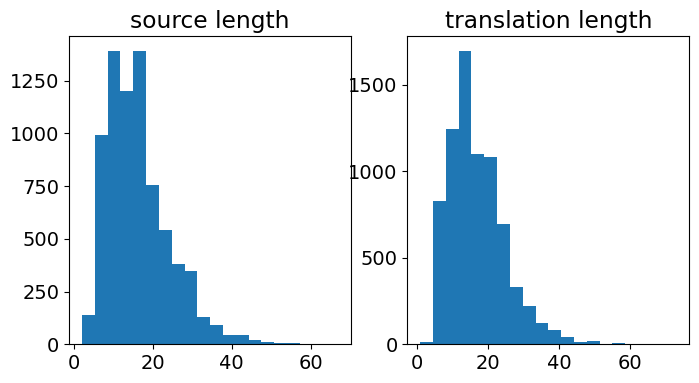

In [52]:
src_length = map(len, [vars(x)["src"] for x in test_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in test_data.examples])

print("Length distribution in Test data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [55]:
def _len_sort_key(x):
    return len(x.src)


BATCH_SIZE = 128 // 4  # 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key,
)

In [56]:
from my_network import Seq2Seq


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# dont forget to put the model to the right device
model = Seq2Seq(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    enc_emb_dim=ENC_EMB_DIM,
    dec_emb_dim=DEC_EMB_DIM,
    enc_hid_dim=ENC_HID_DIM,
    dec_hid_dim=DEC_HID_DIM,
    enc_dropout=ENC_DROPOUT,
    dec_dropout=DEC_DROPOUT,
    enc_n_layers=ENC_N_LAYERS,
    device=device,
).to(device)

In [36]:
# from torchinfo import summary

# sample = next(iter(train_iterator))
# summary(model, input_data=[sample.src, sample.trg])

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [29, 32, 6727]            --
├─Encoder: 1-1                           [29, 32, 1024]            --
│    └─Embedding: 2-1                    [29, 32, 256]             2,365,952
│    └─Dropout: 2-2                      [29, 32, 256]             --
│    └─LSTM: 2-3                         [29, 32, 1024]            9,453,568
│    └─Linear: 2-4                       [32, 512]                 524,800
│    └─Linear: 2-5                       [32, 512]                 (recursive)
├─Decoder: 1-2                           [32, 6727]                --
│    └─Embedding: 2-6                    [1, 32, 256]              1,722,112
│    └─Dropout: 2-7                      [1, 32, 256]              --
│    └─Attention: 2-8                    [32, 29]                  --
│    │    └─Linear: 3-1                  [32, 29, 512]             786,944
│    │    └─Linear: 3-2                  [32,

In [57]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9245, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6716, 256)
    (rnn): LSTM(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6716, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [58]:
print(f"The model has {utils.count_parameters(model):,} trainable parameters")

The model has 30,567,740 trainable parameters


In [59]:
PAD_IDX = TRG.vocab.stoi["<pad>"]
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [60]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float("inf")

In [61]:
def run(n_epochs: int, clip_size: float):
    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train(
            model,
            train_iterator,
            optimizer,
            criterion,
            clip_size,
            train_history,
            valid_history,
        )
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = utils.epoch_time(start_time, end_time)

        # if valid_loss < best_valid_loss:
        #     best_valid_loss = valid_loss
        # torch.save(model.state_dict(), "tut1-model.pt")

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}"
        )
        print(
            f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}"
        )

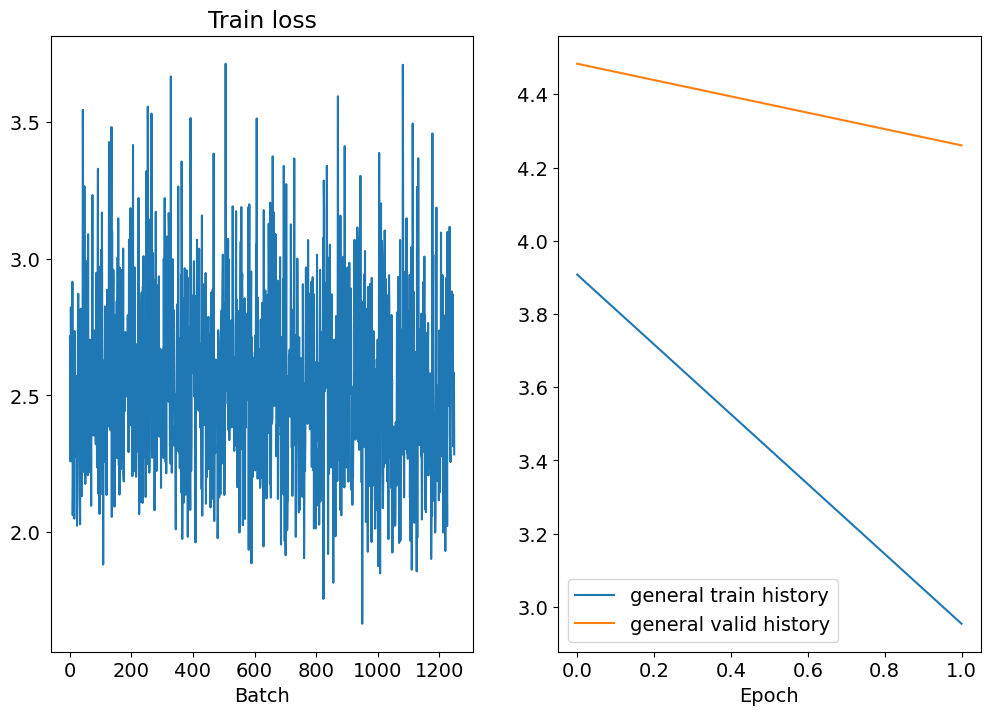

1250it [1:15:52,  3.64s/it]


Epoch: 03 | Time: 76m 5s
	Train Loss: 2.548 | Train PPL:  12.777
	 Val. Loss: 4.148 |  Val. PPL:  63.318


In [62]:
run(N_EPOCHS, CLIP)

__Let's take a look at our network quality__:

In [63]:
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [64]:
batch = next(iter(test_iterator))

In [65]:
for idx in [1, 2]:
    src = batch.src[:, idx : idx + 1]
    trg = batch.trg[:, idx : idx + 1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: free parking is available .

Original: the property offers free parking .
Generated: free parking is available .



In [66]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
# translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
# return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [67]:
import tqdm

In [68]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)  # turn off teacher forcing

        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend(
            [get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T]
        )

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

235it [00:35,  6.71it/s]


In [69]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

28.378245925749884

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points